In [30]:
# Import libraries

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import json
import asyncio
from sklearn import datasets
from tqdm import tqdm
import os
import time

os.environ['ENABLE_ICICLE_GPU'] = 'true'
os.environ['RUST_BACKTRACE']='full'

# check if notebook is in colab
try:
    # install ezkl
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nest_asyncio"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

import ezkl
import os
import nest_asyncio

nest_asyncio.apply()

# Task definition

print('Data information')
print('=' * 20)

images, labels = datasets.load_digits(return_X_y=True)
images = torch.tensor(images, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.int64)
print(f'#samples={len(images)}, image_size={images[0].shape}')

mask = labels % 2 == 1
odd_num_images, odd_num_labels = images[mask], labels[mask]
print(f'#odd_num_images={len(odd_num_images)}')

mask = labels % 2 == 0
even_num_images, even_num_labels = images[mask], labels[mask]
print(f'#even_num_images={len(even_num_images)}')

# Neural network definition
hidden_dim = 256
input_dim = 64
output_dim = 10
num_params = (1 + input_dim) * hidden_dim + (1 + hidden_dim) * output_dim
print(f'num_params={num_params}')


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def get_loss(model, data, labels):
    logits = model(data)
    log_probs = F.log_softmax(logits, dim=1)
    true_log_probs = log_probs.gather(1, labels.view(-1, 1))
    return -true_log_probs.mean()


def get_grad(model, data, labels):
    model.zero_grad()
    loss = get_loss(model, data, labels)
    loss.backward()
    return model.parameters()


def get_acc(logits, labels):
    predicted_labels = logits.argmax(dim=1)
    return (predicted_labels == labels).float().mean().item()


def train(model, x, y, lr=0.003, num_epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for _ in range(num_epochs):
        optimizer.zero_grad()
        loss = get_loss(model, x, y)
        loss.backward()
        optimizer.step()
    return model


# Test
mlp = MLP()
rand_params = torch.randn(num_params) * 0.01
mlp.fc1.weight.data = rand_params[:hidden_dim * input_dim].view(hidden_dim, input_dim)
mlp.fc1.bias.data = rand_params[hidden_dim * input_dim:hidden_dim * input_dim + hidden_dim]
mlp.fc2.weight.data = rand_params[-(output_dim * hidden_dim + output_dim):-output_dim].view(output_dim, hidden_dim)
mlp.fc2.bias.data = rand_params[-output_dim:]


Data information
#samples=1797, image_size=torch.Size([64])
#odd_num_images=906
#even_num_images=891
num_params=19210


In [31]:
print(images.shape)
logits = mlp(images)
loss = get_loss(mlp, images, labels)
acc = get_acc(logits, labels)
print(f'Random MLP: loss={loss.item():.4f}, acc={acc:.2f}')

# Train 2 seed MLPs
mlp1 = MLP()
mlp2 = MLP()

mlp1 = train(mlp1, odd_num_images, odd_num_labels)
mlp2 = train(mlp2, even_num_images, even_num_labels)

models = [mlp1, mlp2]
model_names = ['mlp1', 'mlp2']
for model, model_name in zip(models, model_names):
    for x, y, name in zip([odd_num_images, even_num_images, images], [odd_num_labels, even_num_labels, labels], ['d_odd', 'd_even', 'd0-9']):
        logits = model(x)
        acc = get_acc(logits, y)
        print(f'{model_name} acc@{name}={acc:.2f}')
    print('-' * 10)



torch.Size([1797, 64])
Random MLP: loss=2.3134, acc=0.07
mlp1 acc@d_odd=0.88
mlp1 acc@d_even=0.00
mlp1 acc@d0-9=0.44
----------
mlp2 acc@d_odd=0.00
mlp2 acc@d_even=0.99
mlp2 acc@d0-9=0.49
----------


In [32]:
# Evolutionary algorithm merging class and function definitions
#n_iter = 1000
n_iter = 10
mutation_std = 0.01
#pop_size = 512
#num_elite = 8
pop_size = 10
num_elite = 4
seed = 42

class Slerp(nn.Module):
    def __init__(self):
        super(Slerp, self).__init__()

    '''
    def forward(self, val, x, y):
      norm_x = F.normalize(x, dim=-1)
      norm_y = F.normalize(y, dim=-1)
      dot = torch.sum(norm_x * norm_y, dim=-1, keepdim=True)
      omega = torch.acos(torch.clamp(dot, -1.0, 1.0))
      sin_omega = torch.sin(omega)
      scale_x = torch.sin((1.0 - val) * omega) / sin_omega
      scale_y = torch.sin(val * omega) / sin_omega
      lin_scale_x = 1.0 - val
      lin_scale_y = val
      return torch.where(sin_omega > 1e-6, scale_x * x + scale_y * y, lin_scale_x * x + lin_scale_y * y)
    '''
    def forward(self, val, x, y):
        return val*x + (1-val)*y

slerp = Slerp()
RUN_FOLDER = 'test_merge_dir/'
#import ipdb
'''
def crossover(parents):
    w = torch.rand(1)
    return slerp(w, parents[0], parents[1])
'''
async def calibrate_circuit(val, parent_1, parent_2):
    model_path = os.path.join(RUN_FOLDER + 'slerp.onnx')
    compiled_model_path = os.path.join(RUN_FOLDER + 'network.compiled')
    pk_path = os.path.join(RUN_FOLDER + 'test.pk')
    vk_path = os.path.join(RUN_FOLDER + 'test.vk')
    settings_path = os.path.join(RUN_FOLDER + 'settings.json')
    
    witness_path = os.path.join(RUN_FOLDER + 'witness.json')
    data_path = os.path.join(RUN_FOLDER + 'slerp_input.json')
    torch.onnx.export(
        slerp,                       # the model/module to be exported
        (val, parent_1, parent_2),                 # example inputs
        model_path,                # the file name to save the ONNX model
        export_params=True,          # store the trained parameter weights inside the model file
        opset_version=11,            # the ONNX version to export the model to
        do_constant_folding=True,    # whether to execute constant folding for optimization
        input_names=['val', 'parent_1', 'parent_2'],  # input names
        output_names=['merged_weights']        # output name
        #dynamic_axes={'x': {0: 'batch_size'}, 'y': {0: 'batch_size'}, 'result': {0: 'batch_size'}}  # no dynamic axis for merging
    )


    py_run_args = ezkl.PyRunArgs()
    py_run_args.input_visibility = "public"
    py_run_args.output_visibility = "public"
    py_run_args.param_visibility = "fixed" # "fixed" for params means that the committed to params are used for all proofs

    res = ezkl.gen_settings(model_path, settings_path, py_run_args=py_run_args)
    assert res == True


    # Serialize data into file:
    
    data = dict(input_data = [[val.item()], 
                              torch.rand(*parent_1.shape).detach().numpy().reshape(-1).tolist(), 
                              torch.rand(*parent_2.shape).detach().numpy().reshape(-1).tolist()])
    cal_path = os.path.join(RUN_FOLDER + "calibration.json")

    json.dump(data, open(cal_path, 'w'))

    await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources")
    #await ezkl.calibrate_settings(cal_path, model_path, settings_path)

    res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
    assert res == True

    # srs path
    res = ezkl.get_srs( settings_path)
    

async def zk_verify_merge(val, merge_idx, parent_1, parent_2, iteration, parent_id_1, parent_id_2):
    merge_id = 'iter_' + str(iteration) + '_merge_idx_' + str(merge_idx) + '_p1_' + str(parent_id_1.item()) + '_p2_' + str(parent_id_2.item())
    model_path = os.path.join(RUN_FOLDER + 'slerp.onnx')
    compiled_model_path = os.path.join(RUN_FOLDER + 'network.compiled')
    pk_path = os.path.join(RUN_FOLDER + merge_id + '_test.pk')
    vk_path = os.path.join(RUN_FOLDER + merge_id + '_test.vk')
    settings_path = os.path.join(RUN_FOLDER + 'settings.json')

    witness_path = os.path.join(RUN_FOLDER + 'witness.json')
    data_path = os.path.join(RUN_FOLDER + 'slerp_input_' + merge_id + '.json')

    # now generate the witness file

    data = dict(input_data = [[val.item()], 
                              parent_1.detach().numpy().reshape(-1).tolist(), 
                              parent_2.detach().numpy().reshape(-1).tolist()])
    with open(data_path, "w") as f:
        json.dump(data, f)
    res = await ezkl.gen_witness(data_path, compiled_model_path, witness_path)
    assert os.path.isfile(witness_path)


    # HERE WE SETUP THE CIRCUIT PARAMS
    # WE GOT KEYS
    # WE GOT CIRCUIT PARAMETERS
    # EVERYTHING ANYONE HAS EVER NEEDED FOR ZK
    
    res = ezkl.setup(
            compiled_model_path,
            vk_path,
            pk_path,
        )

    assert res == True
    assert os.path.isfile(vk_path)
    assert os.path.isfile(pk_path)
    assert os.path.isfile(settings_path)

    # GENERATE A PROOF

    proof_path = os.path.join(RUN_FOLDER + merge_id + '_test.pf')

    proof = ezkl.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,

            "single",
        )

    assert os.path.isfile(proof_path)
    return proof
'''
    # VERIFY IT

    res = ezkl.verify(
            proof_path,
            settings_path,
            vk_path
        )

    assert res == True
    print("verified")
    return res
'''


def crossover(parents, iteration, parent_inds, merge_idx):
    val = torch.rand(1)
    loop = asyncio.get_event_loop()
    proof = loop.run_until_complete(zk_verify_merge(val, merge_idx, parents[0], parents[1], iteration, parent_inds[0], parent_inds[1]))
    result = slerp(val, parents[0], parents[1])
    return result, proof


def mutate(gene):
    noise = torch.randn(gene.shape) * mutation_std
    return gene + noise

def ask(elite_solutions, iteration):
    parents_indices = torch.randint(0, num_elite, (pop_size * 2,))
    #ipdb.set_trace()
    parents = elite_solutions[parents_indices].view(pop_size, 2, -1)
    p_inds = parents_indices.view(pop_size, 2)
    #population = torch.stack([crossover(p, iteration, p_inds[i]) for i, p in enumerate(parents)])
    pop_list = []
    proof_list = []
    for merge_idx, p in enumerate(parents):
        merged_model, proof = crossover(p, iteration, p_inds[merge_idx], merge_idx)
        pop_list.append(merged_model)
        proof_list.append(proof)
    population = torch.stack(pop_list)
    population = torch.stack([mutate(g) for g in population])
    return population, proof_list, p_inds

def get_flat_params(model):
    return torch.concatenate([p.view(-1) for p in model.parameters()])

def tell(population, scores, proofs):
    top_scores, top_indices = scores.topk(num_elite)
    new_elites = population[top_indices]
    new_elites_proofs = [proofs[idx] for idx in top_indices]
    new_elites[-1] = get_flat_params(mlp1)
    new_elites[-2] = get_flat_params(mlp2)
    return new_elites, new_elites_proofs, top_indices


def eval_params(params, x, y):
    model = MLP()
    # Load the model's parameters from the flattened params vector, reshaping the weights
    model.fc1.weight.data = params[:hidden_dim * input_dim].view(hidden_dim, input_dim)

    model.fc1.bias.data = params[(hidden_dim * input_dim):(hidden_dim * input_dim + hidden_dim)]

    model.fc2.weight.data = params[-(output_dim * hidden_dim + output_dim):-output_dim].view(output_dim, hidden_dim)

    model.fc2.bias.data = params[-output_dim:]

    # Reshape the input data to match the expected input size of the model
    x_reshaped = x.view(-1, input_dim)  # Reshape to [batch_size, input_dim]

    logits = model(x_reshaped)  # Pass the reshaped input to the model
    return get_acc(logits, y)
    

In [33]:
# Initialize the elites with seed models
mlp1_param = torch.concatenate([mlp1.state_dict()['fc1.weight'].view(-1), mlp1.state_dict()['fc1.bias'].view(-1), mlp1.state_dict()['fc2.weight'].view(-1), mlp1.state_dict()['fc2.bias'].view(-1)])
mlp2_param = torch.concatenate([mlp2.state_dict()['fc1.weight'].view(-1), mlp2.state_dict()['fc1.bias'].view(-1), mlp2.state_dict()['fc2.weight'].view(-1), mlp2.state_dict()['fc2.bias'].view(-1)])
elites = torch.stack([mlp1_param, mlp2_param])
elites = elites[torch.randint(0, 2, (num_elite,))]

# calibrate circuit
val = torch.rand(1)
loop = asyncio.get_event_loop()
calibrate_start = time.time()
verified = loop.run_until_complete(calibrate_circuit(val, mlp1_param, mlp2_param))
calibrate_end = time.time()
calibration_duration = calibrate_end - calibrate_start
print('Calibration duration: ' + str(calibration_duration))

Using 2 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.


 <------------- Numerical Fidelity Report (input_scale: 13, param_scale: 13, scale_input_multiplier: 10) ------------->

+-------------------+----------------+----------------+-----------------+----------------+------------------+----------------+---------------+--------------------+--------------------+------------------------+
| mean_error        | median_error   | max_error      | min_error       | mean_abs_error | median_abs_error | max_abs_error  | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+-------------------+----------------+----------------+-----------------+----------------+------------------+----------------+---------------+--------------------+--------------------+------------------------+
| -0.00000018379511 | 0.000025749207 | 0.000071018934 | -0.000072300434 | 0.000023133283 | 0.000025749207   | 0.000072300434

Calibration duration: 10.293658971786499


100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:28<00:00, 32.84s/it]

Evolutionary model merging with proof generation duration: 328.4251480102539


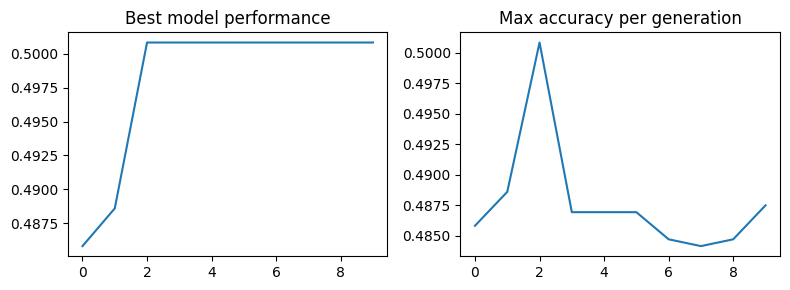

In [34]:
# Optimization loop
acc_max = []
merge_idx_and_p_inds = []

top_model_history = [] # list of parents of top model
all_model_histories = [] # list of lists of parents of current population of models

start_time = time.time()
for i in tqdm(range(n_iter)):
    population, proofs, p_inds = ask(elites, i)
    p_inds_w_merge_idx = torch.concatenate([torch.arange(pop_size).reshape(-1,1), p_inds], dim=1) # concatenated iteration number and all parent indices
    merge_idx_and_p_inds.append(p_inds_w_merge_idx)
    #print(population.shape)
    scores = torch.tensor([eval_params(p, images, labels) for p in population])
    #print('score values')
    #print(scores)
    #elites = tell(elites, scores)
    elites, new_elites_proofs, top_inds = tell(population, scores, proofs)
    acc_max.append(scores.max().item())

merge_idx_and_p_inds = torch.stack(merge_idx_and_p_inds)
best_ind = top_inds[0]

end_time = time.time()
duration = end_time - start_time
print('Evolutionary model merging with proof generation duration: ' + str(duration))
# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

ax = axes[0]
ax.plot(np.maximum.accumulate(acc_max))
ax.set_title('Best model performance')
ax = axes[1]
ax.plot(acc_max)
ax.set_title('Max accuracy per generation')

plt.tight_layout()
plt.show()

In [71]:
print(merge_idx_and_p_inds)
async def verify_proofs(merge_id):
    proof_path = os.path.join(RUN_FOLDER + merge_id + '_test.pf')
    settings_path = os.path.join(RUN_FOLDER + 'settings.json')
    vk_path = os.path.join(RUN_FOLDER + merge_id + '_test.vk')
    #print(proof_path)
    #print(settings_path)
    #print(vk_path)
    assert os.path.isfile(proof_path)
    assert os.path.isfile(settings_path)
    assert os.path.isfile(vk_path)
    res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path
    )

    assert res == True
    print("verified")
    return res
    
async def verify_all_proofs(merge_idx_and_p_inds):
    merge_ids = []
    for iteration, merge_list in enumerate(merge_idx_and_p_inds):
        for merge in merge_list:
            merge_id = 'iter_' + str(iteration) + '_merge_idx_' + str(int(merge[0])) + '_p1_' + str(int(merge[1])) + '_p2_' + str(int(merge[2]))
            merge_ids.append(merge_id)
    await asyncio.gather(*(verify_proofs(merge_id) for merge_id in merge_ids))


async def verify_only_best_path_proofs(merge_idx_and_p_inds, best_ind):
    # given the ending best performing model, get each proof in the tree of proofs that is necessary to prove the parent models
    parents_to_verify = [tuple(merge_idx_and_p_inds[-1][best_ind].tolist())]
    merge_ids = set()
    for iteration in reversed(range(len(merge_idx_and_p_inds))):
        # verify current parents
        new_parents = []
        for parents in parents_to_verify:
            merge_idx = parents[0]
            merge_id = 'iter_' + str(int(iteration)) + '_merge_idx_' + str(int(merge_idx)) + '_p1_' + str(int(parents[1])) + '_p2_' + str(int(parents[2]))
            merge_ids.add(merge_id)
            new_parents.append(tuple(merge_idx_and_p_inds[iteration-1][parents[1]].tolist()))
            new_parents.append(tuple(merge_idx_and_p_inds[iteration-1][parents[2]].tolist()))
            #print('The parents of ' + merge_id + ' are ' + 'iter_' + str(int(iteration-1)) + '_merge_idx_' + str(int(parents[0])) + '_p1_' + str(int(new_parents[0][1])) + '_p2_' + str(int(new_parents[0][2])) + ' and ' \
            #    'iter_' + str(int(iteration-1)) + '_merge_idx_' + str(int(parents[1])) + '_p1_' + str(int(new_parents[1][1])) + '_p2_' + str(int(new_parents[1][2])))
        print('Iteration ' + str(iteration))
        parents_to_verify = set(new_parents) # don't include the same parents twice
        print(parents_to_verify)
        print('number of parents to verify ' + str(len(parents_to_verify)))

    
    return await asyncio.gather(*(verify_proofs(merge_id) for merge_id in merge_ids))


tensor([[[0, 3, 2],
         [1, 2, 0],
         [2, 0, 0],
         [3, 3, 2],
         [4, 2, 1],
         [5, 3, 0],
         [6, 0, 2],
         [7, 3, 0],
         [8, 1, 1],
         [9, 0, 3]],

        [[0, 0, 2],
         [1, 2, 1],
         [2, 1, 0],
         [3, 0, 2],
         [4, 2, 3],
         [5, 0, 1],
         [6, 2, 1],
         [7, 2, 1],
         [8, 3, 3],
         [9, 1, 2]],

        [[0, 2, 1],
         [1, 1, 0],
         [2, 2, 3],
         [3, 3, 2],
         [4, 2, 2],
         [5, 3, 1],
         [6, 2, 2],
         [7, 3, 2],
         [8, 2, 3],
         [9, 3, 0]],

        [[0, 1, 1],
         [1, 3, 0],
         [2, 0, 2],
         [3, 0, 2],
         [4, 0, 2],
         [5, 0, 1],
         [6, 1, 2],
         [7, 0, 3],
         [8, 3, 3],
         [9, 2, 2]],

        [[0, 1, 2],
         [1, 3, 1],
         [2, 1, 1],
         [3, 1, 0],
         [4, 0, 2],
         [5, 1, 3],
         [6, 1, 3],
         [7, 2, 1],
         [8, 1, 0],
         [9,

In [72]:
verify_start = time.time()
best_ind = top_inds[0]
await verify_only_best_path_proofs(merge_idx_and_p_inds, best_ind)
verify_end = time.time()

verify_duration = verify_end - verify_start
print('Proof verification duration (best path):' + str(verify_duration))

Iteration 9
{(2, 0, 0), (0, 0, 3)}
number of parents to verify2
Iteration 8
{(3, 1, 0), (0, 3, 2)}
number of parents to verify2
Iteration 7
{(1, 2, 1), (3, 3, 1), (0, 1, 3), (2, 2, 0)}
number of parents to verify4
Iteration 6
{(0, 1, 2), (3, 0, 1), (2, 2, 0), (1, 2, 0)}
number of parents to verify4
Iteration 5
{(0, 1, 2), (2, 1, 1), (1, 3, 1)}
number of parents to verify3
Iteration 4
{(1, 3, 0), (2, 0, 2), (3, 0, 2)}
number of parents to verify3
Iteration 3
{(2, 2, 3), (0, 2, 1), (3, 3, 2)}
number of parents to verify3
Iteration 2
{(2, 1, 0), (3, 0, 2), (1, 2, 1)}
number of parents to verify3
Iteration 1
{(2, 0, 0), (0, 3, 2), (1, 2, 0)}
number of parents to verify3
Iteration 0
{(2, 1, 0), (3, 1, 0), (0, 3, 2)}
number of parents to verify3
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verifie

In [68]:
verify_start = time.time()
await verify_all_proofs(merge_idx_and_p_inds)
#best_ind = top_inds[0]
#await verify_only_best_path_proofs(merge_idx_and_p_inds, best_ind)
verify_end = time.time()

verify_duration = verify_end - verify_start
print('Proof verification duration (all):' + str(verify_duration))

verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified


CancelledError: 